In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns


In [ ]:
# Load models
nas_model = tf.keras.models.load_model('/content/best_MobileNetV2.h5')
mobilenet_model = tf.keras.models.load_model('/content/skin_cancer_nas_model.h5')  # adjust filename if needed


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nischaydnk/isic-2020-jpg-256x256-resized")

print("Path to dataset files:", path)

100%|██████████| 595M/595M [00:03<00:00, 165MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nischaydnk/isic-2020-jpg-256x256-resized/versions/1


In [ ]:
import os

# List the dataset directory
print("Dataset files:", os.listdir(path))


Dataset files: ['.ipynb_checkpoints', 'train-image', 'train-metadata.csv']


In [ ]:
# prompt: define my dataset paths, image_dir and csv_path

image_dir = os.path.join(path, 'train-image/image')
csv_path = os.path.join(path, 'train-metadata.csv')


In [ ]:
df = pd.read_csv(csv_path)

# Display the first few rows
print(df.head())


   Unnamed: 0       isic_id  patient_id  target
0           0  ISIC_2637011  IP_7279968       0
1           1  ISIC_0015719  IP_3075186       0
2           2  ISIC_0052212  IP_2842074       0
3           3  ISIC_0068279  IP_6890425       0
4           4  ISIC_0074268  IP_8723313       0


In [ ]:
image_folder = os.path.join(path, "train-image/image")

# List first 10 images
print(os.listdir(image_folder)[:10])

['ISIC_4614604.jpg', 'ISIC_1307134.jpg', 'ISIC_7109582.jpg', 'ISIC_9059632.jpg', 'ISIC_3289574.jpg', 'ISIC_6502168.jpg', 'ISIC_3183653.jpg', 'ISIC_0422139.jpg', 'ISIC_7313348.jpg', 'ISIC_9361625.jpg']


In [ ]:
# Load dataframe
df = pd.read_csv(csv_path)
df['image_name'] = df['isic_id'].astype(str) + ".jpg"
df['path'] = df['image_name'].apply(lambda x: os.path.join(image_folder, x))
df['label'] = df['target']

# Split into train and test for comparison
from sklearn.model_selection import train_test_split
_, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

test_df['label'] = test_df['label'].astype(str)

# Create test generator
datagen = ImageDataGenerator(rescale=1./255)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 6626 validated image filenames belonging to 2 classes.


Found 6626 validated image filenames belonging to 2 classes.
  1/208 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step
Found 6626 validated image filenames belonging to 2 classes.
  1/208 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step
True labels shape: (6626,)
NAS labels shape: (6626,)
MobileNet labels shape: (6626,)

NAS Model Classification Report
              precision    recall  f1-score   support

   Malignant       0.98      1.00      0.99      6509
      Benign       0.31      0.04      0.08       117

    accuracy                           0.98      6626
   macro avg       0.65      0.52      0.53      6626
weighted avg       0.97      0.98      0.97      6626



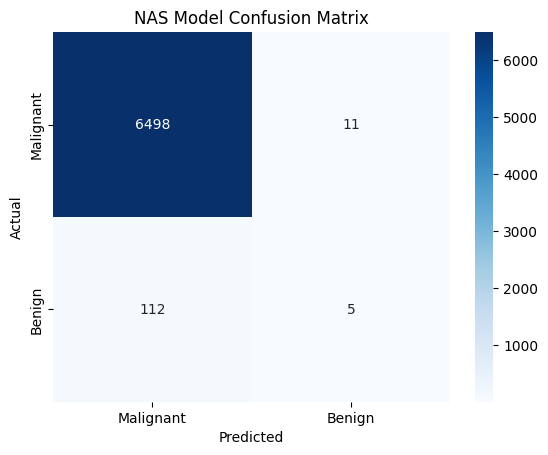


MobileNet Model Classification Report
              precision    recall  f1-score   support

   Malignant       0.98      0.50      0.66      6509
      Benign       0.02      0.51      0.03       117

    accuracy                           0.50      6626
   macro avg       0.50      0.51      0.35      6626
weighted avg       0.97      0.50      0.65      6626



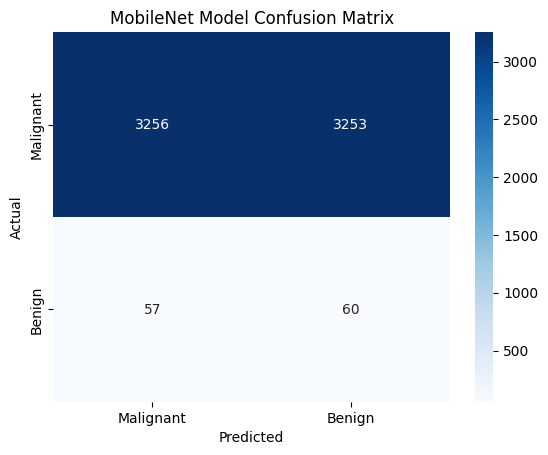

In [ ]:
# --- Helper to recreate the generator ---
def create_test_generator(df, image_dir):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        class_mode='binary',
        batch_size=32,
        shuffle=False
    )

# Get true labels directly from dataframe and convert to integers
true_labels = test_df['label'].astype(int).values

# --- Predict with NAS Model ---
test_gen_nas = create_test_generator(test_df, image_dir)
nas_preds = nas_model.predict(test_gen_nas, steps=len(test_gen_nas))
nas_labels = (nas_preds > 0.5).astype(int).flatten()

# --- Predict with MobileNet Model ---
test_gen_mob = create_test_generator(test_df, image_dir)
num_samples = len(test_df)
batch_size = 32
num_steps = (num_samples + batch_size - 1) // batch_size  # Ceiling division

mobilenet_preds = mobilenet_model.predict(test_gen_mob, steps=num_steps)
mobilenet_labels = (mobilenet_preds > 0.5).astype(int).flatten()

# Ensure we have exactly the right number of predictions
mobilenet_labels = mobilenet_labels[:num_samples]

# Print shapes to debug
print(f"True labels shape: {true_labels.shape}")
print(f"NAS labels shape: {nas_labels.shape}")
print(f"MobileNet labels shape: {mobilenet_labels.shape}")

# --- Evaluate both ---
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Classification Report")
    print(classification_report(y_true, y_pred, target_names=["Malignant", "Benign"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Malignant", "Benign"], yticklabels=["Malignant", "Benign"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("NAS Model", true_labels, nas_labels)
evaluate_model("MobileNet Model", true_labels, mobilenet_labels)

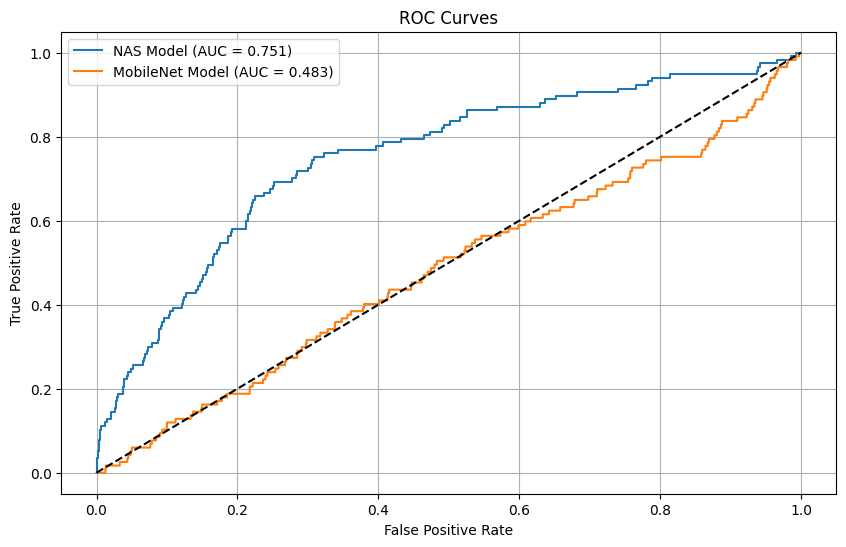

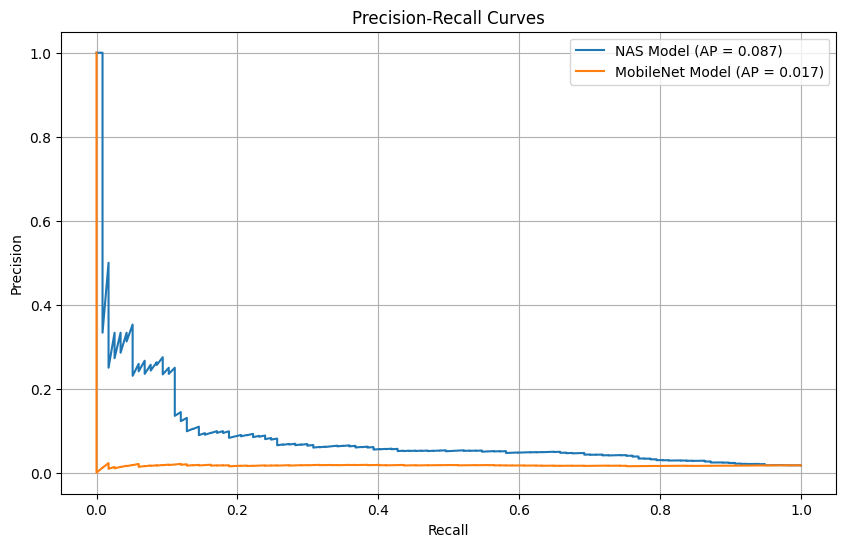


Detailed Performance Metrics:

NAS Model:
Sensitivity: 0.043
Specificity: 0.998
F1 Score: 0.075
Accuracy: 0.981

MobileNet Model:
Sensitivity: 0.513
Specificity: 0.500
F1 Score: 0.035
Accuracy: 0.500

Model Characteristics:
NAS Model Parameters: 2,259,265
MobileNet Model Parameters: 172,450


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, nas_preds, mobilenet_preds):
    # Ensure predictions are 1D arrays and have correct length
    nas_preds_1d = nas_preds.flatten()
    mobilenet_preds_1d = mobilenet_preds.flatten()[:len(y_true)]  # Only use first len(y_true) predictions

    # Calculate ROC curves
    fpr_nas, tpr_nas, _ = roc_curve(y_true, nas_preds_1d)
    fpr_mob, tpr_mob, _ = roc_curve(y_true, mobilenet_preds_1d)

    # Calculate AUC scores
    auc_nas = auc(fpr_nas, tpr_nas)
    auc_mob = auc(fpr_mob, tpr_mob)

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_nas, tpr_nas, label=f'NAS Model (AUC = {auc_nas:.3f})')
    plt.plot(fpr_mob, tpr_mob, label=f'MobileNet Model (AUC = {auc_mob:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_precision_recall_curve(y_true, nas_preds, mobilenet_preds):
    # Ensure predictions are 1D arrays and have correct length
    nas_preds_1d = nas_preds.flatten()
    mobilenet_preds_1d = mobilenet_preds.flatten()[:len(y_true)]  # Only use first len(y_true) predictions

    # Calculate precision-recall curves
    precision_nas, recall_nas, _ = precision_recall_curve(y_true, nas_preds_1d)
    precision_mob, recall_mob, _ = precision_recall_curve(y_true, mobilenet_preds_1d)

    # Calculate average precision scores
    ap_nas = average_precision_score(y_true, nas_preds_1d)
    ap_mob = average_precision_score(y_true, mobilenet_preds_1d)

    # Plot precision-recall curves
    plt.figure(figsize=(10, 6))
    plt.plot(recall_nas, precision_nas, label=f'NAS Model (AP = {ap_nas:.3f})')
    plt.plot(recall_mob, precision_mob, label=f'MobileNet Model (AP = {ap_mob:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_metrics(y_true, nas_preds, mobilenet_preds):
    # Ensure predictions are 1D arrays and have correct length
    nas_preds_1d = nas_preds.flatten()
    mobilenet_preds_1d = mobilenet_preds.flatten()[:len(y_true)]  # Only use first len(y_true) predictions

    # Calculate additional metrics
    metrics = {}

    # For NAS Model
    tn_nas, fp_nas, fn_nas, tp_nas = confusion_matrix(y_true, nas_preds_1d > 0.5).ravel()
    metrics['NAS'] = {
        'Sensitivity': tp_nas / (tp_nas + fn_nas),
        'Specificity': tn_nas / (tn_nas + fp_nas),
        'F1 Score': 2 * (tp_nas / (tp_nas + fn_nas)) * (tp_nas / (tp_nas + fp_nas)) / ((tp_nas / (tp_nas + fn_nas)) + (tp_nas / (tp_nas + fp_nas))),
        'Accuracy': (tp_nas + tn_nas) / (tp_nas + tn_nas + fp_nas + fn_nas)
    }

    # For MobileNet Model
    tn_mob, fp_mob, fn_mob, tp_mob = confusion_matrix(y_true, mobilenet_preds_1d > 0.5).ravel()
    metrics['MobileNet'] = {
        'Sensitivity': tp_mob / (tp_mob + fn_mob),
        'Specificity': tn_mob / (tn_mob + fp_mob),
        'F1 Score': 2 * (tp_mob / (tp_mob + fn_mob)) * (tp_mob / (tp_mob + fp_mob)) / ((tp_mob / (tp_mob + fn_mob)) + (tp_mob / (tp_mob + fp_mob))),
        'Accuracy': (tp_mob + tn_mob) / (tp_mob + tn_mob + fp_mob + fn_mob)
    }

    return metrics

# Plot ROC curves
plot_roc_curve(true_labels, nas_preds, mobilenet_preds)

# Plot Precision-Recall curves
plot_precision_recall_curve(true_labels, nas_preds, mobilenet_preds)

# Calculate and print additional metrics
metrics = calculate_metrics(true_labels, nas_preds, mobilenet_preds)

print("\nDetailed Performance Metrics:")
print("\nNAS Model:")
for metric, value in metrics['NAS'].items():
    print(f"{metric}: {value:.3f}")

print("\nMobileNet Model:")
for metric, value in metrics['MobileNet'].items():
    print(f"{metric}: {value:.3f}")

# Compare model sizes and inference times
print("\nModel Characteristics:")
print(f"NAS Model Parameters: {nas_model.count_params():,}")
print(f"MobileNet Model Parameters: {mobilenet_model.count_params():,}")